# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [128]:
import pandas as pd
import numpy as np
import holidays
from meteostat import Point, Daily
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

np.random.seed(42)
random.seed(42)

## Prepare data

### Load data

In [2]:
aqi_pd = pd.read_csv("../data/air_quality_history.csv", skipinitialspace=True)

In [3]:
# Make sure column names are stripped
aqi_pd.columns

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [4]:
aqi_pd["date"] = pd.to_datetime(aqi_pd["date"], format="%Y/%m/%d")

In [5]:
aqi_pd = aqi_pd.set_index("date")

In [6]:
aqi_pd.head()

,pm25,pm10,no2,so2,co
date,,,,,
2025-07-01,28.0,12.0,3.0,1.0,5.0
2025-07-02,41.0,22.0,7.0,1.0,5.0
2025-07-03,65.0,16.0,3.0,NaN,5.0
2025-07-04,42.0,12.0,3.0,1.0,5.0
2025-07-05,41.0,14.0,2.0,1.0,5.0


In [7]:
aqi_pd.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1297.000000,1297.000000,1288.000000,1202.000000,1290.000000
mean,44.865073,15.110254,5.603261,3.143095,3.976744
std,18.265603,7.783591,3.761774,1.700122,1.555616
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,44.000000,14.000000,5.000000,3.000000,4.000000
75%,56.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [8]:
full_range = pd.date_range(start=aqi_pd.index.min(), end=aqi_pd.index.max(), freq="D")

# Check for missing dates
full_range.difference(aqi_pd.index)

DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')

In [9]:
aqi_pd.loc[pd.Timestamp("2024-12-30")] = aqi_pd.loc[pd.Timestamp("2024-12-31")]
aqi_pd = aqi_pd.sort_index()

In [10]:
full_range.difference(aqi_pd.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

### Handle N/A values

In [11]:
aqi_pd.isna().sum()

pm25     3
pm10     2
no2     11
so2     97
co       9
dtype: int64

In [12]:
aqi_pd = aqi_pd.fillna(aqi_pd.median())

In [13]:
aqi_pd.isna().sum()

pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64

## Feature engineering

### Calendar Features

In [14]:
svk_holidays = holidays.Slovakia()

datetime_pd = aqi_pd.index

aqi_pd["year"] = datetime_pd.year
aqi_pd["month"] = datetime_pd.month
aqi_pd["day_of_month"] = datetime_pd.day
aqi_pd["day_of_week"] = datetime_pd.dayofweek
aqi_pd["day_of_year"] = datetime_pd.dayofyear
aqi_pd["week_of_year"] = datetime_pd.isocalendar().week
aqi_pd["is_leap_year"] = datetime_pd.is_leap_year.astype(int)
aqi_pd["is_working_day"] = [int(svk_holidays.is_working_day(x)) for x in datetime_pd]
aqi_pd["is_feb29"] = ((aqi_pd["month"] == 2) & (aqi_pd["day_of_month"] == 29)).astype(int)

### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [15]:
# Define Poprad coordinates
# Coordinates of Poprad-Tatry Airport (LZTT) meteo station.
location = Point(49.07, 20.24, 718)  # Lat, Lon, Elevation (optional but good)

start_date = datetime_pd.min()
end_date = datetime_pd.max()

daily_weather = Daily(location, start_date, end_date)
weather_pd = daily_weather.fetch()

print(weather_pd.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2021-12-27 -13.1 -17.2  -8.0  <NA>  <NA>  <NA>   2.7  13.0  1009.1  <NA>
2021-12-28  -9.3 -13.8  -2.0  <NA>  <NA>  <NA>   4.0  13.0  1006.6  <NA>
2021-12-29  -4.1  -8.1  -0.9  <NA>  <NA>  <NA>   4.8  14.8  1005.6  <NA>
2021-12-30  -3.6  -9.6   1.8  <NA>  <NA>  <NA>   4.7  13.0  1015.0  <NA>
2021-12-31   3.9  -0.2   8.2  <NA>  <NA>  <NA>  15.2  33.3  1017.1  <NA>


In [16]:
weather_pd.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,1300.0,1300.0,1300.0,1165.0,4.0,0.0,1300.0,1289.0,1300.0,0.0
mean,7.847923,2.567154,13.119231,2.114764,2.0,<NA>,12.482077,26.591777,1016.236,<NA>
std,7.977937,7.356673,9.118355,4.390847,1.414214,<NA>,6.636817,9.29342,7.995956,<NA>
min,-13.1,-20.2,-8.0,0.0,1.0,<NA>,2.6,11.1,987.5,<NA>
25%,1.175,-3.0,6.0,0.0,1.0,<NA>,7.8,20.4,1011.6,<NA>
50%,7.7,2.9,13.1,0.1,1.5,<NA>,10.5,24.1,1016.8,<NA>
75%,14.6,8.525,20.725,2.1,2.5,<NA>,15.325,31.5,1021.2,<NA>
max,24.5,18.4,34.0,42.7,4.0,<NA>,47.8,57.4,1039.8,<NA>


In [17]:
# No data available for these features from selected meteo station
weather_pd.drop(["wdir", "tsun"], axis=1, inplace=True)

In [18]:
weather_pd.isna().sum()

tavg       0
tmin       0
tmax       0
prcp     135
snow    1296
wspd       0
wpgt      11
pres       0
dtype: int64

In [19]:
# N/A here means that there was no rain or snow - so filling with 0 instead
weather_pd["prcp"] = weather_pd["prcp"].fillna(0.0)
weather_pd["snow"] = weather_pd["snow"].fillna(0.0)

# Let's assume that rest N/A is just missing reading, and fill with median
weather_pd.fillna(weather_pd.median(), inplace=True)

In [20]:
weather_pd.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64

In [21]:
merged_df = pd.merge_asof(aqi_pd, weather_pd, left_on="date", right_on="time")

In [22]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
0,44.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
1,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
3,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
4,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [23]:
merged_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co', 'year', 'month', 'day_of_month',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_leap_year',
       'is_working_day', 'is_feb29', 'tavg', 'tmin', 'tmax', 'prcp', 'snow',
       'wspd', 'wpgt', 'pres'],
      dtype='object')

## Explore trends

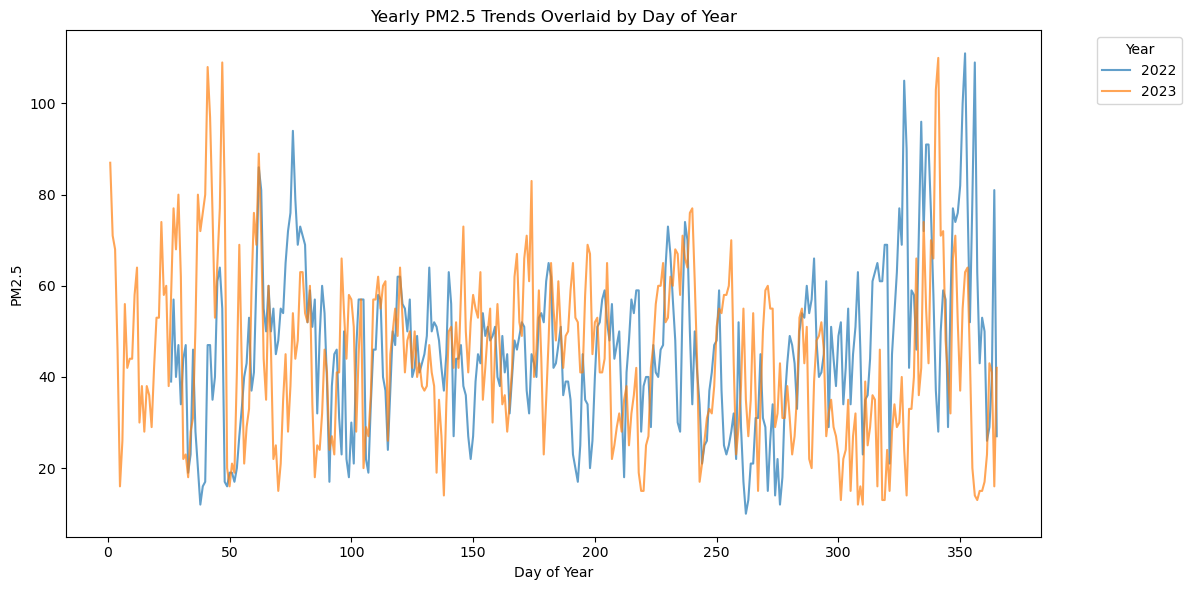

In [25]:
plt.figure(figsize=(12, 6))
for year, group in aqi_pd.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

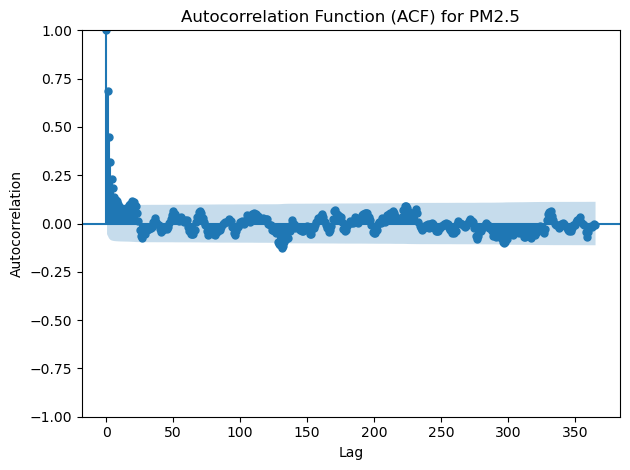

In [26]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_pd["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

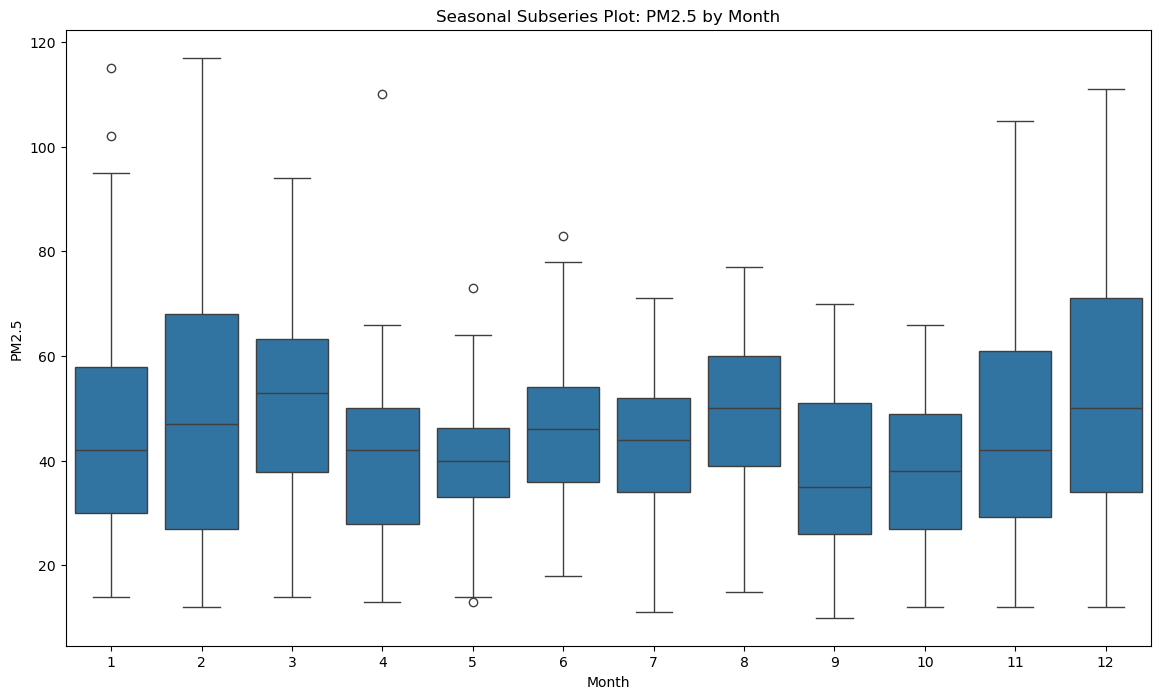

In [27]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_pd)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

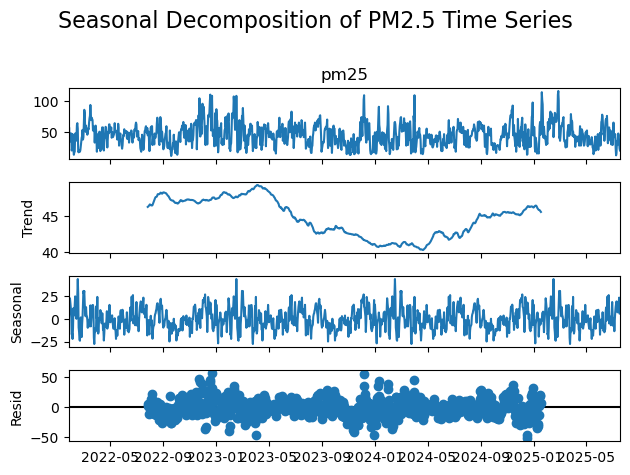

In [28]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_pd["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

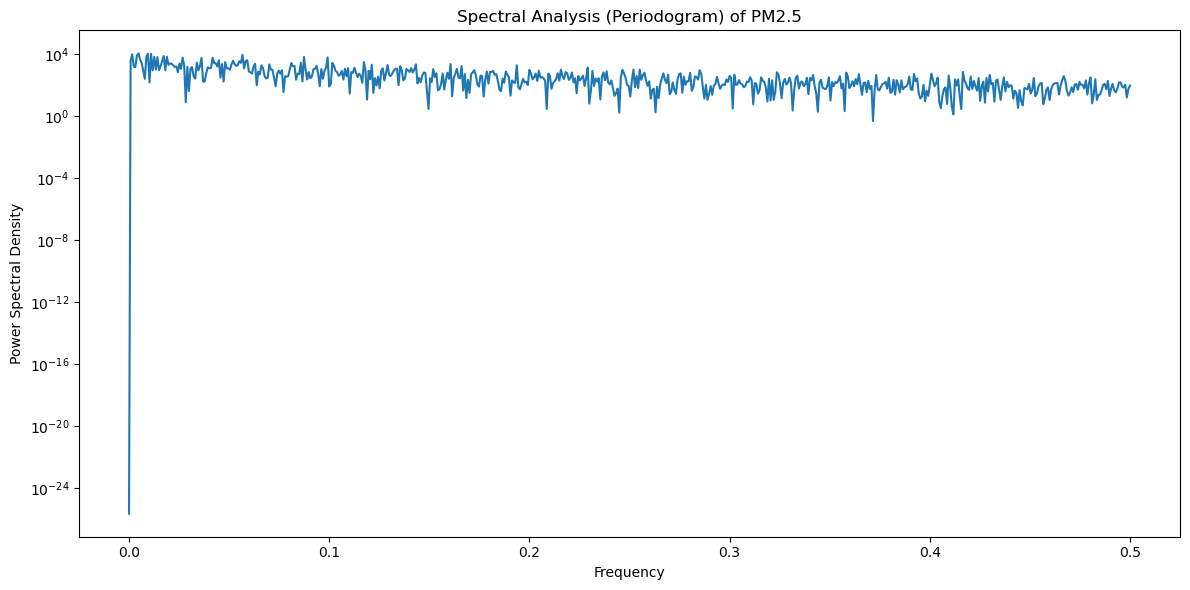

In [29]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_pd["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [ ]:
train_size = int(len(merged_df) * 0.8)
val_size = int(len(merged_df) * 0.1)

train_df = merged_df.iloc[:train_size]
val_df = merged_df.iloc[train_size : train_size + val_size]
test_df = merged_df.iloc[train_size + val_size :]

target_columns = ["pm25", "pm10", "no2", "so2", "co"]

# Since lagged target columns are used as input, let's keep whole DataFrame for X
X_train, y_train = train_df, train_df[target_columns]
X_val, y_val = val_df, val_df[target_columns]
X_test, y_test = test_df, test_df[target_columns]

## Feature Scaling

TODO:
Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant.

## Prepare prediction windows

In [97]:
def split_to_windows(X, y, window_size):
    original_input_size = X.shape[0]

    X_new = []
    y_new = []
    for i in range(original_input_size - window_size - window_size + 1):
        X_window = X[i : i + window_size]
        X_new.append(X_window)

        y_window = y[i + window_size : i + window_size + window_size]
        y_new.append(y_window)
    
    return X_new, y_new

In [98]:
# Let's first keep X window and y window same size
window_size = 3

X_window_train, y_window_train = split_to_windows(X_train, y_train, window_size)
X_window_val, y_window_val = split_to_windows(X_val, y_val, window_size)
X_window_test, y_window_test = split_to_windows(X_test, y_test, window_size)

In [99]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
1034,57.0,28.0,4.0,4.0,4.0,2024,10,26,5,300,...,0,0,7.3,1.1,15.2,0.0,0.0,4.8,16.7,1024.8
1035,63.0,28.0,9.0,2.0,4.0,2024,10,27,6,301,...,0,0,12.9,7.4,18.6,0.0,0.0,12.3,24.1,1021.8
1036,61.0,18.0,9.0,2.0,4.0,2024,10,28,0,302,...,1,0,8.4,3.9,12.3,0.0,0.0,6.0,14.8,1025.8


In [100]:
y_window_train[-1]

,pm25,pm10,no2,so2,co
1037,45.0,19.0,8.0,3.0,4.0
1038,48.0,11.0,6.0,2.0,3.0
1039,26.0,17.0,7.0,2.0,4.0


## Training and Evaluation

In [101]:
def flatten_windows(X, y):
    X_flat = np.array([window.values.flatten() for window in X])
    y_flat = np.array([window.values.flatten() for window in y])
    return X_flat, y_flat

In [102]:
# Flatten for regressors
X_flat_train, y_flat_train = flatten_windows(X_window_train, y_window_train)
X_flat_val, y_flat_val = flatten_windows(X_window_val, y_window_val)
X_flat_test, y_flat_test = flatten_windows(X_window_test, y_window_test)

### Decision Tree

In [103]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_flat_train, y_flat_train)

DecisionTreeRegressor()

In [104]:
y_pred = dt_regressor.predict(X_flat_test)

In [105]:
def evaluate_predictions(y_true, y_pred, window_size):
    n_outputs = y_true.shape[1]

    for window_index in range(window_size):
        print(f"Day {window_index+1}:")
        for output_index in range(n_outputs // window_size):
            i = output_index + window_size * window_index

            print(f"Metrics for Output {output_index+1} ({target_columns[output_index]}):")
            print(f"  MAE: {mean_absolute_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  MSE: {mean_squared_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])):.4f}")
            print(f"  R2 Score: {r2_score(y_true[:, i], y_pred[:, i]):.4f}")
            print("-" * 20)

In [106]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 7.2400
  MSE: 101.7200
  RMSE: 10.0856
  R2 Score: 0.4826
--------------------
Metrics for Output 2 (pm10):
  MAE: 5.6560
  MSE: 53.3360
  RMSE: 7.3032
  R2 Score: -1.1294
--------------------
Metrics for Output 3 (no2):
  MAE: 2.1120
  MSE: 8.0960
  RMSE: 2.8453
  R2 Score: -1.0170
--------------------
Metrics for Output 4 (so2):
  MAE: 1.4880
  MSE: 3.2800
  RMSE: 1.8111
  R2 Score: -2.9194
--------------------
Metrics for Output 5 (co):
  MAE: 1.7280
  MSE: 3.8720
  RMSE: 1.9677
  R2 Score: -25.8889
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 1.4880
  MSE: 3.2800
  RMSE: 1.8111
  R2 Score: -2.9194
--------------------
Metrics for Output 2 (pm10):
  MAE: 1.7280
  MSE: 3.8720
  RMSE: 1.9677
  R2 Score: -25.8889
--------------------
Metrics for Output 3 (no2):
  MAE: 15.4400
  MSE: 350.0960
  RMSE: 18.7109
  R2 Score: -0.7609
--------------------
Metrics for Output 4 (so2):
  MAE: 5.0240
  MSE: 51.7280
  RMSE: 7.1922
  R2 S

In [ ]:
# TODO: pandas with column names instead of numpy array

feature_names = []
for i in reversed(range(window_size)):
    for column in X_train.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

Top 10 important features for Decision Tree:
pm10_lag_1d: 0.3834
pres_lag_1d: 0.0419
tmax_lag_2d: 0.0356
tmax_lag_1d: 0.0338
pres_lag_3d: 0.0321
tmin_lag_2d: 0.0240
tmin_lag_1d: 0.0233
pres_lag_2d: 0.0197
wpgt_lag_3d: 0.0196
no2_lag_1d: 0.0180


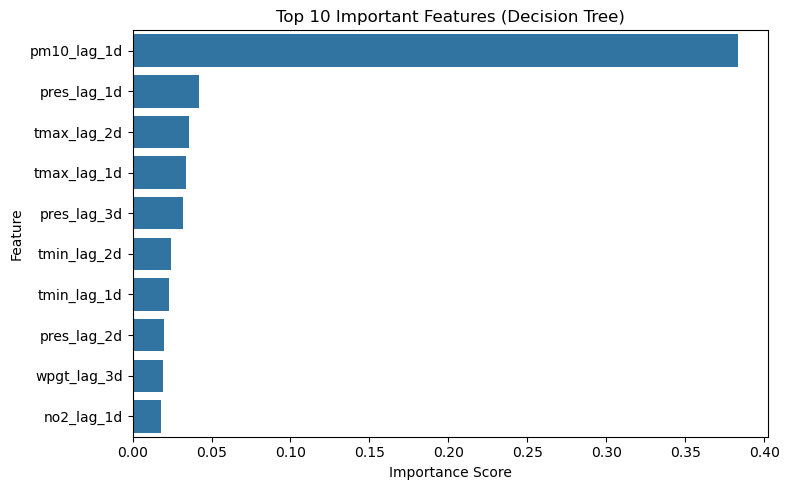

In [ ]:
importances = dt_regressor.feature_importances_
feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Decision Tree:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()

### Random Forest

In [123]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_flat_train, y_flat_train)

RandomForestRegressor()

In [124]:
y_pred = rf_regressor.predict(X_flat_test)

In [125]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 5.8751
  MSE: 80.3200
  RMSE: 8.9621
  R2 Score: 0.5915
--------------------
Metrics for Output 2 (pm10):
  MAE: 3.3600
  MSE: 17.2526
  RMSE: 4.1536
  R2 Score: 0.3112
--------------------
Metrics for Output 3 (no2):
  MAE: 1.5589
  MSE: 3.7060
  RMSE: 1.9251
  R2 Score: 0.0767
--------------------
Metrics for Output 4 (so2):
  MAE: 0.5827
  MSE: 0.6204
  RMSE: 0.7876
  R2 Score: 0.2587
--------------------
Metrics for Output 5 (co):
  MAE: 1.5605
  MSE: 2.6102
  RMSE: 1.6156
  R2 Score: -17.1266
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.5827
  MSE: 0.6204
  RMSE: 0.7876
  R2 Score: 0.2587
--------------------
Metrics for Output 2 (pm10):
  MAE: 1.5605
  MSE: 2.6102
  RMSE: 1.6156
  R2 Score: -17.1266
--------------------
Metrics for Output 3 (no2):
  MAE: 9.9277
  MSE: 153.9463
  RMSE: 12.4075
  R2 Score: 0.2257
--------------------
Metrics for Output 4 (so2):
  MAE: 3.8484
  MSE: 25.3103
  RMSE: 5.0309
  R2 Score: -0

Top 10 important features for Random Forest:
pm10_lag_1d: 0.3820
pres_lag_1d: 0.0333
tmax_lag_1d: 0.0283
tavg_lag_1d: 0.0277
no2_lag_1d: 0.0240
tmax_lag_2d: 0.0194
pres_lag_3d: 0.0191
tavg_lag_2d: 0.0188
tmin_lag_1d: 0.0168
tmin_lag_3d: 0.0167


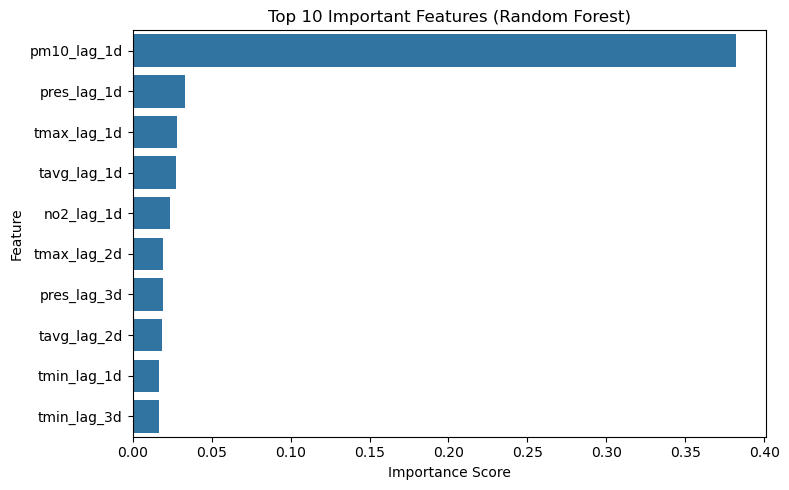

In [127]:
importances = rf_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Random Forest:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [129]:
base_regressor = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

multi_regressor = MultiOutputRegressor(base_regressor)
multi_regressor.fit(X_flat_train, y_flat_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [130]:
y_pred = multi_regressor.predict(X_flat_test)

In [131]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 5.0568
  MSE: 59.7425
  RMSE: 7.7293
  R2 Score: 0.6961
--------------------
Metrics for Output 2 (pm10):
  MAE: 3.2857
  MSE: 17.8637
  RMSE: 4.2265
  R2 Score: 0.2868
--------------------
Metrics for Output 3 (no2):
  MAE: 1.4050
  MSE: 3.1419
  RMSE: 1.7725
  R2 Score: 0.2172
--------------------
Metrics for Output 4 (so2):
  MAE: 0.4495
  MSE: 0.3593
  RMSE: 0.5994
  R2 Score: 0.5706
--------------------
Metrics for Output 5 (co):
  MAE: 0.8411
  MSE: 0.8238
  RMSE: 0.9076
  R2 Score: -4.7208
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.4495
  MSE: 0.3593
  RMSE: 0.5994
  R2 Score: 0.5706
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.8411
  MSE: 0.8238
  RMSE: 0.9076
  R2 Score: -4.7208
--------------------
Metrics for Output 3 (no2):
  MAE: 9.8444
  MSE: 150.9043
  RMSE: 12.2843
  R2 Score: 0.2410
--------------------
Metrics for Output 4 (so2):
  MAE: 4.1113
  MSE: 26.1340
  RMSE: 5.1121
  R2 Score: -0.0

In [132]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(target_columns):  # Replace with your target names
    estimator = multi_regressor.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.2854
 2. pm25_lag_1d          : 0.2368
 3. no2_lag_1d           : 0.0753
 4. tmax_lag_1d          : 0.0266
 5. month_lag_2d         : 0.0234
 6. month_lag_1d         : 0.0219
 7. pres_lag_1d          : 0.0174
 8. wspd_lag_1d          : 0.0164
 9. tmax_lag_2d          : 0.0144
10. day_of_year_lag_1d   : 0.0140

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1222
 2. pm25_lag_1d          : 0.0463
 3. pm10_lag_2d          : 0.0432
 4. no2_lag_1d           : 0.0417
 5. pres_lag_1d          : 0.0319
 6. day_of_year_lag_2d   : 0.0258
 7. pm25_lag_2d          : 0.0257
 8. day_of_week_lag_1d   : 0.0248
 9. day_of_year_lag_1d   : 0.0237
10. day_of_week_lag_3d   : 0.0218

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.2179
 2. tavg_lag_1d          : 0.0918
 3. is_working_day_lag_2d : 0.0432
 4. day_of_year_lag_1d   : 0.0313
 5. tmin_lag_1d          : 0.0297
 6. tmin_lag_2d          : 0.0270
 7. day_of_year_lag_2d   : 0.0263
 8. tav